In [1]:
import os
import matplotlib.pyplot as plt
import scanpy as sc
import anndata2ri
import logging
from scipy.sparse import csr_matrix, issparse
import numpy as np
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

import pandas as pd
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import scipy as sp

import scanpy.external as sce
import scib
import matplotlib



import sys
from sklearn.linear_model import LinearRegression
import preprocessing
import utils
import check_if_nan

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

os.chdir('/root/host_home')

-----
anndata     0.10.7
scanpy      1.10.1
-----
PIL                         10.1.0
anndata2ri                  1.3.1
anyio                       NA
arrow                       1.3.0
asttokens                   NA
astunparse                  1.6.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.14.0
backcall                    0.2.0
cairo                       1.26.0
certifi                     2023.11.17
cffi                        1.16.0
chardet                     5.2.0
charset_normalizer          3.3.2
check_if_nan                NA
cloudpickle                 3.0.0
comm                        0.2.1
cupy                        12.3.0
cupy_backends               NA
cupyx                       NA
cycler                      0.12.1
cython_runtime              NA
cytoolz                     0.12.3
dask                        2023.11.0
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.

In [2]:
%%R -o Rpackages

library(scran)
library(BiocParallel)
library(biomaRt)
library(scry)

print(R.version)
Rpackages = as.data.frame(installed.packages())


               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          2.3                         
year           2023                        
month          03                          
day            15                          
svn rev        83980                       
language       R                           
version.string R version 4.2.3 (2023-03-15)
nickname       Shortstop Beagle            


Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOr

In [3]:
a = pd.DataFrame(Rpackages)
a.to_csv('Rversions.csv')

# Common Filenames

In [4]:
#Filename scanpy AnnData input for lp NPC after demultiplexing
adata_input_lp = 'lp_NPCs/processed_data/lp_NPC_clustered_scvi_cuda.h5ad'
adata_input_hp = 'hp_NPCs/processed_data/hp_NPC_clustered_scvi_cuda_soup.h5ad'

#Filename scanpy AnnData output for NPC after demultiplexing
adata_out_normalized = 'NPCs_merge/processed_data/NPC_normalized_cuda.h5ad'
adata_out_cell_cycle = 'NPCs_merge/processed_data/NPC_cell_cycle_cuda.h5ad'

save_dir = 'NPCs_merge/'


In [5]:
lane_key = "lane"
donor_key = "Donor"
dataset_key = "cultivation_period"
label_key = "condition"

# Read and prepare lp dataset

In [6]:
adata_lp = sc.read(adata_input_lp)

In [7]:
adata_lp

AnnData object with n_obs × n_vars = 30843 × 17250
    obs: 'Donor', 'lane', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'doublet_score', 'size_factors', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'Ferroptosis_pos_corr', 'Ferroptosis_neg_corr', 'Apoptosis_pos_corr', 'Apoptosis_neg_corr', 'Necroptosis_pos_corr', 'Autophagy_pos_corr', 'Pathanatos_pos_corr', 'cell_types', 'cell_types_abbrev'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_genes', 'highly_variable_nbatches', '

In [8]:
adata_lp.X = adata_lp.layers['soupX_counts']

In [9]:
del adata_lp.obsm
del adata_lp.obsp
del adata_lp.varm
del adata_lp.uns
del adata_lp.raw
del adata_lp.layers

In [10]:
# Remove unnecessary var
keys = ['highly_variable', 'dispersions', 'dispersions_norm', 'highly_variable_genes', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable_genes_batch_aware', 'n_cells', 'means']

for i in keys:
    del adata_lp.var[i]

In [11]:
# Remove unnecessary obs
keys = ['doublet_score', 'size_factors', '_scvi_batch', '_scvi_labels', 'Ferroptosis_pos_corr', 'Ferroptosis_neg_corr', 'Apoptosis_pos_corr', 'Apoptosis_neg_corr', 'Necroptosis_pos_corr', 'Autophagy_pos_corr', 'Pathanatos_pos_corr']

for i in keys:
    del adata_lp.obs[i]


In [12]:
adata_lp

AnnData object with n_obs × n_vars = 30843 × 17250
    obs: 'Donor', 'lane', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'S_score', 'G2M_score', 'phase', 'cell_types', 'cell_types_abbrev'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols'

In [13]:
adata_lp.obs

Donor       lane  condition   age  \
AAACCCAAGACTCTAC-23L013539  UKERiC99-R1-007  23L013539  Parkinson  68.0   
AAACCCAAGATCACCT-23L013539  UKERiG3G-R1-039  23L013539    Control  69.0   
AAACCCACAATAGAGT-23L013539  UKERiAY6-R1-003  23L013539  Parkinson  37.0   
AAACCCACAGGTTACT-23L013539  UKERiPX7-R1-001  23L013539  Parkinson  49.0   
AAACCCACATCGATAC-23L013539  UKERiG3G-R1-039  23L013539    Control  69.0   
...                                     ...        ...        ...   ...   
TTTGTTGGTCATATGC-23L013540  UKERiC99-R1-007  23L013540  Parkinson  68.0   
TTTGTTGGTTCGAACT-23L013540  UKERiPX7-R1-001  23L013540  Parkinson  49.0   
TTTGTTGGTTCTCAGA-23L013540  UKERiPX7-R1-001  23L013540  Parkinson  49.0   
TTTGTTGTCGGTCGGT-23L013540  UKERiPX7-R1-001  23L013540  Parkinson  49.0   
TTTGTTGTCGTTCTGC-23L013540  UKERiG3G-R1-039  23L013540    Control  69.0   

                            years_of_illness  deltaHY  deltaUPDRS  deltaADL  \
AAACCCAAGACTCTAC-23L013539               7.0      2.5        36.0      -0.5   
AAACCCAAGATCACCT-23L013539               NaN      NaN         NaN       NaN   
AAACCCACAATAGAGT-23L013539               4.0      1.0        -1.0      -0.2   
AAACCCACAGGTTACT-23L013539               1.0      1.0         0.0      -0.1   
AAACCCACATCGATAC-23L013539               NaN      NaN         NaN       NaN   
...                                      ...      ...         ...       ...   
TTTGTTGGTCATATGC-23L013540               7.0      2.5        36.0      -0.5   
TTTGTTGGTTCGAACT-23L013540               1.0      1.0         0.0      -0.1   
TTTGTTGGTTCTCAGA-23L013540               1.0      1.0         0.0      -0.1   
TTTGTTGTCGGTCGGT-23L013540               1.0      1.0         0.0      -0.1   
TTTGTTGTCGTTCTGC-23L013540               NaN      NaN         NaN       NaN   

                            deltaDOPA gender  ... pct_counts_ribo  \
AAACCCAAGACTCTAC-23L013539      610.0      M  ...       20.447332   
AAACCCAAGATCACCT-23L013539        NaN      F  ...       20.539436   
AAACCCACAATAGAGT-23L013539      800.0      M  ...       16.765802   
AAACCCACAGGTTACT-23L013539     1900.0      M  ...       24.365837   
AAACCCACATCGATAC-23L013539        NaN      F  ...       20.356316   
...                               ...    ...  ...             ...   
TTTGTTGGTCATATGC-23L013540      610.0      M  ...       29.756922   
TTTGTTGGTTCGAACT-23L013540     1900.0      M  ...       25.788418   
TTTGTTGGTTCTCAGA-23L013540     1900.0      M  ...       13.570733   
TTTGTTGTCGGTCGGT-23L013540     1900.0      M  ...       17.993732   
TTTGTTGTCGTTCTGC-23L013540        NaN      F  ...       24.403296   

                            total_counts_hb  log1p_total_counts_hb  \
AAACCCAAGACTCTAC-23L013539              6.0               1.945910   
AAACCCAAGATCACCT-23L013539              1.0               0.693147   
AAACCCACAATAGAGT-23L013539              0.0               0.000000   
AAACCCACAGGTTACT-23L013539              1.0               0.693147   
AAACCCACATCGATAC-23L013539              3.0               1.386294   
...                                     ...                    ...   
TTTGTTGGTCATATGC-23L013540              1.0               0.693147   
TTTGTTGGTTCGAACT-23L013540              0.0               0.000000   
TTTGTTGGTTCTCAGA-23L013540              0.0               0.000000   
TTTGTTGTCGGTCGGT-23L013540              0.0               0.000000   
TTTGTTGTCGTTCTGC-23L013540              2.0               1.098612   

                            pct_counts_hb  n_counts   S_score  G2M_score  \
AAACCCAAGACTCTAC-23L013539       0.023218   25842.0  0.367943  -0.071660   
AAACCCAAGATCACCT-23L013539       0.003932   25434.0  0.358278   0.298565   
AAACCCACAATAGAGT-23L013539       0.000000   22528.0  0.346207   0.354457   
AAACCCACAGGTTACT-23L013539       0.007757   12891.0  0.615251  -0.079397   
AAACCCACATCGATAC-23L013539       0.019295   15548.0  0.050731   0.599592   
...                                   ...       ...       ... 

In [14]:
adata_lp.var

gene_ids    feature_types  \
ATAD3B           ENSG00000160072  Gene Expression   
PRDM16           ENSG00000142611  Gene Expression   
PEX10            ENSG00000157911  Gene Expression   
PEX14            ENSG00000142655  Gene Expression   
PLCH2            ENSG00000149527  Gene Expression   
...                          ...              ...   
ENSG00000276256  ENSG00000276256  Gene Expression   
ENSG00000273748  ENSG00000273748  Gene Expression   
ENSG00000278817  ENSG00000278817  Gene Expression   
ENSG00000276345  ENSG00000276345  Gene Expression   
ENSG00000271254  ENSG00000271254  Gene Expression   

                                                         genome  \
ATAD3B           homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
PRDM16           homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
PEX10            homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
PEX14            homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
PLCH2            homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
...                                                         ...   
ENSG00000276256  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
ENSG00000273748  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
ENSG00000278817  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
ENSG00000276345  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
ENSG00000271254  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   

                    gene_symbols  
ATAD3B                    ATAD3B  
PRDM16                    PRDM16  
PEX10                      PEX10  
PEX14                      PEX14  
PLCH2                      PLCH2  
...                          ...  
ENSG00000276256  ENSG00000276256  
ENSG00000273748  ENSG00000273748  
ENSG00000278817  ENSG00000278817  
ENSG00000276345  ENSG00000276345  
ENSG00000271254  ENSG00000271254  

[17250 rows x 4 columns]

# Read and prepare hp dataset

In [15]:
adata_hp = sc.read(adata_input_hp)

In [16]:
adata_hp

AnnData object with n_obs × n_vars = 30557 × 16774
    obs: 'lane', 'Demux_state', 'Donor', 'cell_types', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'batch', 'size_factors', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'Ferroptosis_pos_corr', 'Ferroptosis_neg_corr', 'Apoptosis_pos_corr', 'Apoptosis_neg_corr', 'Necroptosis_pos_corr', 'Autophagy_pos_corr', 'Pathanatos_pos_corr', 'cell_types_abbrev'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_co

In [17]:
adata_hp.X = adata_hp.layers['soupX_counts']

In [18]:
del adata_hp.obsm
del adata_hp.obsp
del adata_hp.varm
del adata_hp.uns
del adata_hp.raw
del adata_hp.layers

In [19]:
# Remove unnecessary var
keys = ['mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',  'highly_variable', 'dispersions', 'dispersions_norm', 
        'highly_variable_genes', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable_genes_batch_aware', 'n_cells', 'means']

for i in keys:
    del adata_hp.var[i]

In [20]:
# Remove unnecessary obs
keys = ['Demux_state', 'batch', 'size_factors', '_scvi_batch', '_scvi_labels', 'Ferroptosis_pos_corr', 'Ferroptosis_neg_corr', 'Apoptosis_pos_corr', 'Apoptosis_neg_corr', 'Necroptosis_pos_corr', 'Autophagy_pos_corr', 'Pathanatos_pos_corr']

for i in keys:
    del adata_hp.obs[i]


In [21]:
adata_hp

AnnData object with n_obs × n_vars = 30557 × 16774
    obs: 'lane', 'Donor', 'cell_types', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'S_score', 'G2M_score', 'phase', 'cell_types_abbrev'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols'

In [22]:
adata_hp.obs

lane            Donor        cell_types  condition   age  \
AAACCTGCACGTCTCT-128  128  UKERi1E4-R1-003              NCSC    Control  53.0   
AAACCTGCAGTATCTG-128  128  UKERiO3H-R1-005             NSC1a    Control  71.0   
AAACCTGTCCAGTATG-128  128  UKERi88H-R1-002             NSC2a  Parkinson  63.0   
AAACCTGTCCCAACGG-128  128  UKERiG3G-R1-039             NSC1a    Control  69.0   
AAACCTGTCCCGGATG-128  128  UKERi1E4-R1-003              NCSC    Control  53.0   
...                   ...              ...               ...        ...   ...   
TTTGTCAGTGTAACGG-133  133  UKERiC99-R1-007             NSC1b  Parkinson  68.0   
TTTGTCAGTTCTCATT-133  133  UKERi88H-R1-002              NCSC  Parkinson  63.0   
TTTGTCATCAGCAACT-133  133  UKERiC99-R1-007  Glial precursors  Parkinson  68.0   
TTTGTCATCTACGAGT-133  133  UKERiAY6-R1-003             NSC1a  Parkinson  37.0   
TTTGTCATCTTAGCCC-133  133  UKERiC99-R1-007             NSC1a  Parkinson  68.0   

                      years_of_illness  deltaHY  deltaUPDRS  deltaADL  \
AAACCTGCACGTCTCT-128               NaN      NaN         NaN       NaN   
AAACCTGCAGTATCTG-128               NaN      NaN         NaN       NaN   
AAACCTGTCCAGTATG-128               6.0      2.0         7.0      -0.3   
AAACCTGTCCCAACGG-128               NaN      NaN         NaN       NaN   
AAACCTGTCCCGGATG-128               NaN      NaN         NaN       NaN   
...                                ...      ...         ...       ...   
TTTGTCAGTGTAACGG-133               7.0      2.5        36.0      -0.5   
TTTGTCAGTTCTCATT-133               6.0      2.0         7.0      -0.3   
TTTGTCATCAGCAACT-133               7.0      2.5        36.0      -0.5   
TTTGTCATCTACGAGT-133               4.0      1.0        -1.0      -0.2   
TTTGTCATCTTAGCCC-133               7.0      2.5        36.0      -0.5   

                      deltaDOPA  ... total_counts_ribo  \
AAACCTGCACGTCTCT-128        NaN  ...            7103.0   
AAACCTGCAGTATCTG-128        NaN  ...            3946.0   
AAACCTGTCCAGTATG-128      640.0  ...            4380.0   
AAACCTGTCCCAACGG-128        NaN  ...            4390.0   
AAACCTGTCCCGGATG-128        NaN  ...            5356.0   
...                         ...  ...               ...   
TTTGTCAGTGTAACGG-133      610.0  ...            2614.0   
TTTGTCAGTTCTCATT-133      640.0  ...            4722.0   
TTTGTCATCAGCAACT-133      610.0  ...            5350.0   
TTTGTCATCTACGAGT-133      800.0  ...            3021.0   
TTTGTCATCTTAGCCC-133      610.0  ...            3110.0   

                     log1p_total_counts_ribo  pct_counts_ribo  \
AAACCTGCACGTCTCT-128                8.868413        36.506142   
AAACCTGCAGTATCTG-128                8.280711        27.116549   
AAACCTGTCCAGTATG-128                8.385033        21.282799   
AAACCTGTCCCAACGG-128                8.387312        26.219913   
AAACCTGTCCCGGATG-128                8.586160        28.146515   
...                                      ...              ...   
TTTGTCAGTGTAACGG-133                7.869020        22.315178   
TTTGTCAGTTCTCATT-133                8.460199        27.594671   
TTTGTCATCAGCAACT-133                8.585039        24.632811   
TTTGTCATCTACGAGT-133                8.013674        20.015902   
TTTGTCATCTTAGCCC-133                8.042700        20.845900   

                      total_counts_hb  log1p_total_counts_hb  pct_counts_hb  \
AAACCTGCACGTCTCT-128              2.0               1.098612       0.010279   
AAACCTGCAGTATCTG-128              4.0               1.609438       0.027488   
AAACCTGTCCAGTATG-128              2.0               1.098612       0.009718   
AAACCTGTCCCAACGG-128              2.0               1.098612       0.011945   
AAACCTGTCCCGGATG-128              2.0               1.098612       0.010510   
...                               ...                    ...            ...   
TTTGTCAGTGTAACGG-133              0.0               0.000000       0.000000   
TTTGTCAGTTCTCATT-133              0.0               0.000000 

In [23]:
adata_hp.var

gene_ids    feature_types  \
ATAD3B           ENSG00000160072  Gene Expression   
PRDM16           ENSG00000142611  Gene Expression   
PEX10            ENSG00000157911  Gene Expression   
PEX14            ENSG00000142655  Gene Expression   
PLCH2            ENSG00000149527  Gene Expression   
...                          ...              ...   
ENSG00000276256  ENSG00000276256  Gene Expression   
ENSG00000273748  ENSG00000273748  Gene Expression   
ENSG00000278817  ENSG00000278817  Gene Expression   
ENSG00000276345  ENSG00000276345  Gene Expression   
ENSG00000271254  ENSG00000271254  Gene Expression   

                                                         genome  \
ATAD3B           homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
PRDM16           homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
PEX10            homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
PEX14            homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
PLCH2            homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
...                                                         ...   
ENSG00000276256  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
ENSG00000273748  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
ENSG00000278817  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
ENSG00000276345  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   
ENSG00000271254  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1   

                    gene_symbols  
ATAD3B                    ATAD3B  
PRDM16                    PRDM16  
PEX10                      PEX10  
PEX14                      PEX14  
PLCH2                      PLCH2  
...                          ...  
ENSG00000276256  ENSG00000276256  
ENSG00000273748  ENSG00000273748  
ENSG00000278817  ENSG00000278817  
ENSG00000276345  ENSG00000276345  
ENSG00000271254  ENSG00000271254  

[16774 rows x 4 columns]

# Combine lp and hp datasets

In [24]:
adata = adata_lp.concatenate(adata_hp, batch_key = dataset_key, batch_categories = ['lp', 'hp'], index_unique = None, join="outer")
adata

AnnData object with n_obs × n_vars = 61400 × 17366
    obs: 'Donor', 'lane', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'S_score', 'G2M_score', 'phase', 'cell_types', 'cell_types_abbrev'
    var: 'gene_ids-hp', 'feature_types-hp', 'genome-hp', 'gene_symbols-hp', 'gene_ids-lp', 'feature_types-lp', 'genome-lp', 'gene_symbols-lp'

In [25]:
adata.var['gene_ids'] = pd.Categorical(np.where(adata.var['gene_ids-lp'].isna(), adata.var['gene_ids-hp'] , adata.var['gene_ids-lp']))
adata.var['feature_types'] = pd.Categorical(np.where(adata.var['feature_types-lp'].isna(), adata.var['feature_types-hp'] , adata.var['feature_types-lp']))
adata.var['genome'] = pd.Categorical(np.where(adata.var['genome-lp'].isna(), adata.var['genome-hp'] , adata.var['genome-lp']))
adata.var['gene_symbols'] = pd.Categorical(np.where(adata.var['gene_symbols-lp'].isna(), adata.var['gene_symbols-hp'] , adata.var['gene_symbols-lp']))

In [26]:
# Remove unnecessary var
keys = ['gene_ids-lp', 'feature_types-lp', 'genome-lp', 'gene_symbols-lp', 'gene_ids-hp', 'feature_types-hp', 'genome-hp', 'gene_symbols-hp']

for i in keys:
    del adata.var[i]

In [27]:
del adata_lp
del adata_hp

In [28]:
adata

AnnData object with n_obs × n_vars = 61400 × 17366
    obs: 'Donor', 'lane', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'S_score', 'G2M_score', 'phase', 'cell_types', 'cell_types_abbrev'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols'

In [29]:
adata.obs

Donor       lane  condition   age  \
AAACCCAAGACTCTAC-23L013539  UKERiC99-R1-007  23L013539  Parkinson  68.0   
AAACCCAAGATCACCT-23L013539  UKERiG3G-R1-039  23L013539    Control  69.0   
AAACCCACAATAGAGT-23L013539  UKERiAY6-R1-003  23L013539  Parkinson  37.0   
AAACCCACAGGTTACT-23L013539  UKERiPX7-R1-001  23L013539  Parkinson  49.0   
AAACCCACATCGATAC-23L013539  UKERiG3G-R1-039  23L013539    Control  69.0   
...                                     ...        ...        ...   ...   
TTTGTCAGTGTAACGG-133        UKERiC99-R1-007        133  Parkinson  68.0   
TTTGTCAGTTCTCATT-133        UKERi88H-R1-002        133  Parkinson  63.0   
TTTGTCATCAGCAACT-133        UKERiC99-R1-007        133  Parkinson  68.0   
TTTGTCATCTACGAGT-133        UKERiAY6-R1-003        133  Parkinson  37.0   
TTTGTCATCTTAGCCC-133        UKERiC99-R1-007        133  Parkinson  68.0   

                            years_of_illness  deltaHY  deltaUPDRS  deltaADL  \
AAACCCAAGACTCTAC-23L013539               7.0      2.5        36.0      -0.5   
AAACCCAAGATCACCT-23L013539               NaN      NaN         NaN       NaN   
AAACCCACAATAGAGT-23L013539               4.0      1.0        -1.0      -0.2   
AAACCCACAGGTTACT-23L013539               1.0      1.0         0.0      -0.1   
AAACCCACATCGATAC-23L013539               NaN      NaN         NaN       NaN   
...                                      ...      ...         ...       ...   
TTTGTCAGTGTAACGG-133                     7.0      2.5        36.0      -0.5   
TTTGTCAGTTCTCATT-133                     6.0      2.0         7.0      -0.3   
TTTGTCATCAGCAACT-133                     7.0      2.5        36.0      -0.5   
TTTGTCATCTACGAGT-133                     4.0      1.0        -1.0      -0.2   
TTTGTCATCTTAGCCC-133                     7.0      2.5        36.0      -0.5   

                            deltaDOPA gender  ... pct_counts_ribo  \
AAACCCAAGACTCTAC-23L013539      610.0      M  ...       20.447332   
AAACCCAAGATCACCT-23L013539        NaN      F  ...       20.539436   
AAACCCACAATAGAGT-23L013539      800.0      M  ...       16.765802   
AAACCCACAGGTTACT-23L013539     1900.0      M  ...       24.365837   
AAACCCACATCGATAC-23L013539        NaN      F  ...       20.356316   
...                               ...    ...  ...             ...   
TTTGTCAGTGTAACGG-133            610.0      M  ...       22.315178   
TTTGTCAGTTCTCATT-133            640.0      F  ...       27.594671   
TTTGTCATCAGCAACT-133            610.0      M  ...       24.632811   
TTTGTCATCTACGAGT-133            800.0      M  ...       20.015902   
TTTGTCATCTTAGCCC-133            610.0      M  ...       20.845900   

                            total_counts_hb  log1p_total_counts_hb  \
AAACCCAAGACTCTAC-23L013539              6.0               1.945910   
AAACCCAAGATCACCT-23L013539              1.0               0.693147   
AAACCCACAATAGAGT-23L013539              0.0               0.000000   
AAACCCACAGGTTACT-23L013539              1.0               0.693147   
AAACCCACATCGATAC-23L013539              3.0               1.386294   
...                                     ...                    ...   
TTTGTCAGTGTAACGG-133                    0.0               0.000000   
TTTGTCAGTTCTCATT-133                    0.0               0.000000   
TTTGTCATCAGCAACT-133                    1.0               0.693147   
TTTGTCATCTACGAGT-133                    0.0               0.000000   
TTTGTCATCTTAGCCC-133                    6.0               1.945910   

                            pct_counts_hb  n_counts   S_score  G2M_score  \
AAACCCAAGACTCTAC-23L013539       0.023218   25842.0  0.367943  -0.071660   
AAACCCAAGATCACCT-23L013539       0.003932   25434.0  0.358278   0.298565   
AAACCCACAATAGAGT-23L013539       0.000000   22528.0  0.346207   0.354457   
AAACCCACAGGTTACT-23L013539       0.007757   12891.0  0.615251  -0.079397   
AAACCCACATCGATAC-23L013539       0.019295   15548.0  0.050731   0.599592   
...                                   ...       ...       ... 

In [30]:
adata.var

gene_ids    feature_types  \
A1BG     ENSG00000121410  Gene Expression   
A1CF     ENSG00000148584  Gene Expression   
A2M      ENSG00000175899  Gene Expression   
A2ML1    ENSG00000166535  Gene Expression   
A3GALT2  ENSG00000184389  Gene Expression   
...                  ...              ...   
ZYG11A   ENSG00000203995  Gene Expression   
ZYG11B   ENSG00000162378  Gene Expression   
ZYX      ENSG00000159840  Gene Expression   
ZZEF1    ENSG00000074755  Gene Expression   
ZZZ3     ENSG00000036549  Gene Expression   

                                                 genome gene_symbols  
A1BG     homo_sapiens_GRCh38_ensembl_release108_cr7.0.1         A1BG  
A1CF     homo_sapiens_GRCh38_ensembl_release108_cr7.0.1         A1CF  
A2M      homo_sapiens_GRCh38_ensembl_release108_cr7.0.1          A2M  
A2ML1    homo_sapiens_GRCh38_ensembl_release108_cr7.0.1        A2ML1  
A3GALT2  homo_sapiens_GRCh38_ensembl_release108_cr7.0.1      A3GALT2  
...                                                 ...          ...  
ZYG11A   homo_sapiens_GRCh38_ensembl_release108_cr7.0.1       ZYG11A  
ZYG11B   homo_sapiens_GRCh38_ensembl_release108_cr7.0.1       ZYG11B  
ZYX      homo_sapiens_GRCh38_ensembl_release108_cr7.0.1          ZYX  
ZZEF1    homo_sapiens_GRCh38_ensembl_release108_cr7.0.1        ZZEF1  
ZZZ3     homo_sapiens_GRCh38_ensembl_release108_cr7.0.1         ZZZ3  

[17366 rows x 4 columns]

In [31]:
#Check dataset stats
adata.obs['cultivation_period'].value_counts()
adata.obs['lane'].value_counts()
adata.obs['Donor'].value_counts()


cultivation_period
lp    30843
hp    30557
Name: count, dtype: int64

lane
23L013539    15699
23L013540    15144
133           5284
132           5278
131           5160
130           5114
129           4911
128           4810
Name: count, dtype: int64

Donor
UKERiPX7-R1-001    7511
UKERiC99-R1-007    6633
UKERi88H-R1-002    6259
UKERiO3H-R1-005    6002
UKERi1E4-R1-003    5852
UKERiAY6-R1-003    5570
UKERiG3G-R1-039    5274
UKERiR66-R1-007    5033
UKERiJ2C-R1-015    3849
UKERi82A-R1-002    3348
UKERiM89-R1-005    3177
UKERi1JF-R1-018    2892
Name: count, dtype: int64

In [32]:
adata.obs.condition.value_counts()
adata.obs.age.value_counts()
adata.obs.years_of_illness.value_counts()
adata.obs.gender.value_counts()

condition
Parkinson    38032
Control      23368
Name: count, dtype: int64

age
49.0    7511
68.0    6633
63.0    6259
71.0    6002
53.0    5852
37.0    5570
69.0    5274
54.0    5033
73.0    3849
66.0    3348
64.0    3177
42.0    2892
Name: count, dtype: int64

years_of_illness
3.0    12059
1.0     7511
7.0     6633
6.0     6259
4.0     5570
Name: count, dtype: int64

gender
M    46519
F    14881
Name: count, dtype: int64

In [33]:
adata.layers['soupX_counts'] = adata.X

# Visualize stats for combined dataset

In [34]:
# Quality control - calculate QC covariates

# mitochondrial genes
adata.var['mt'] = adata.var.gene_symbols.str.startswith('MT-')
# ribosomal genes
adata.var['ribo'] = adata.var.gene_symbols.str.startswith(('RPS', 'RPL'))
# hemoglobin genes.
adata.var['hb'] = adata.var.gene_symbols.str.contains(('^HB[^(P)]'))

sc.pp.calculate_qc_metrics(
    adata, qc_vars=['mt', 'ribo', 'hb'], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 61400 × 17366
    obs: 'Donor', 'lane', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'S_score', 'G2M_score', 'phase', 'cell_types', 'cell_types_abbrev'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'soupX_counts'

In [35]:
if not os.path.exists(save_dir+'figures'):
    # Create a new directory because it does not exist
    os.mkdir(save_dir+'figures')
    print("The new directory: "+save_dir+"figures is created!")
else: 
    print("The directory "+save_dir+"figures already exists")

The directory NPCs_merge/figures already exists


In [36]:
if not os.path.exists(save_dir+'figures/QC'):
    # Create a new directory because it does not exist
    os.mkdir(save_dir+'figures/QC')
    print("The new directory: "+save_dir+"figures/QC is created!")
else: 
    print("The directory "+save_dir+"figures/QC already exists")

The directory NPCs_merge/figures/QC already exists


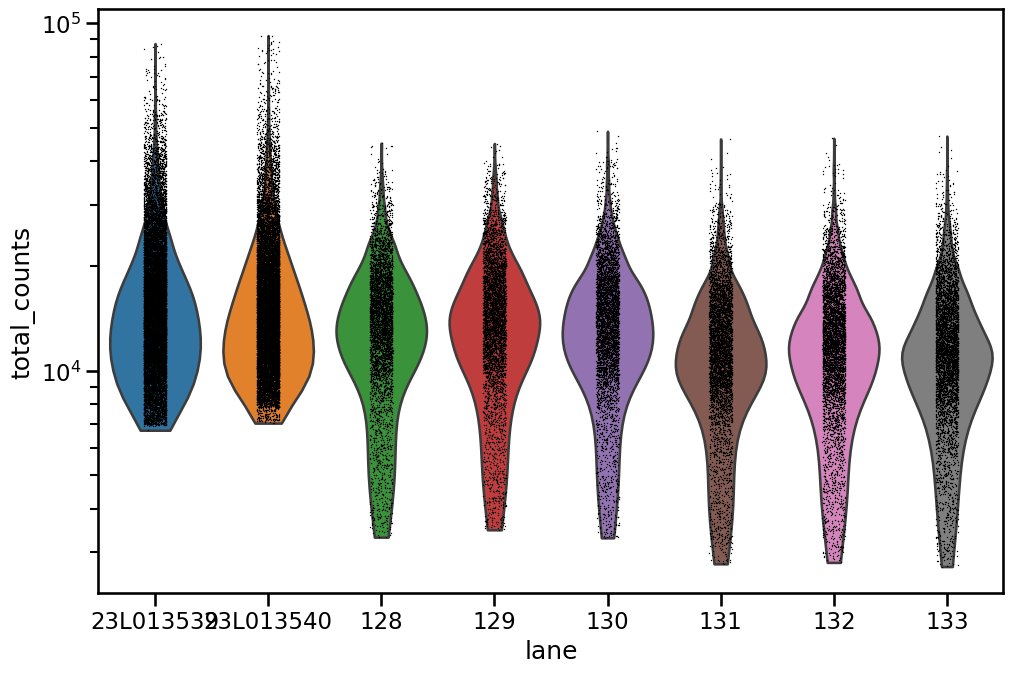

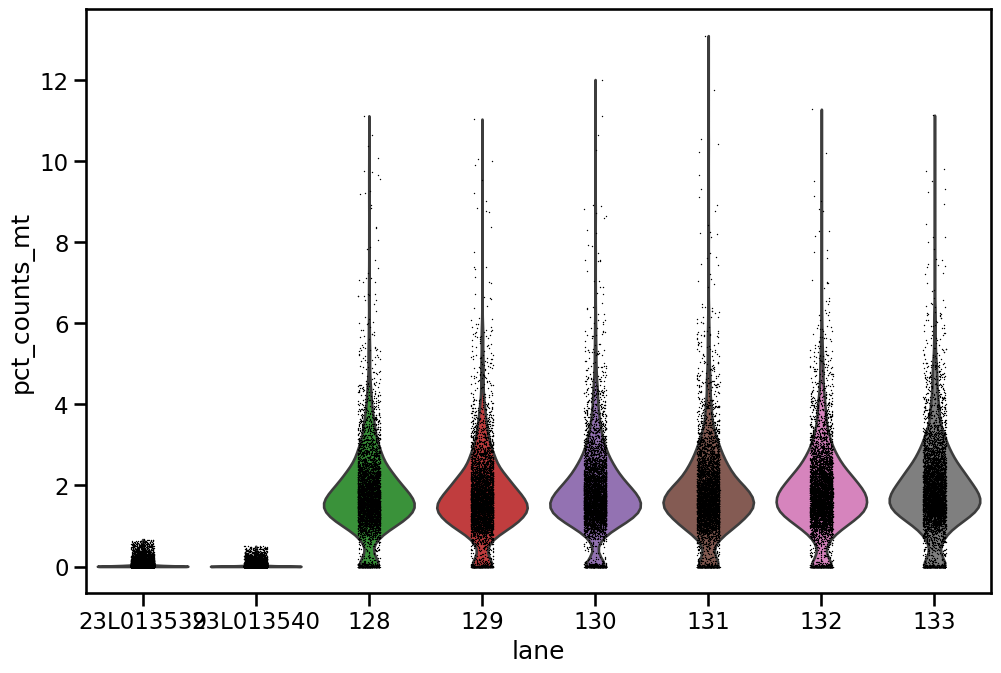

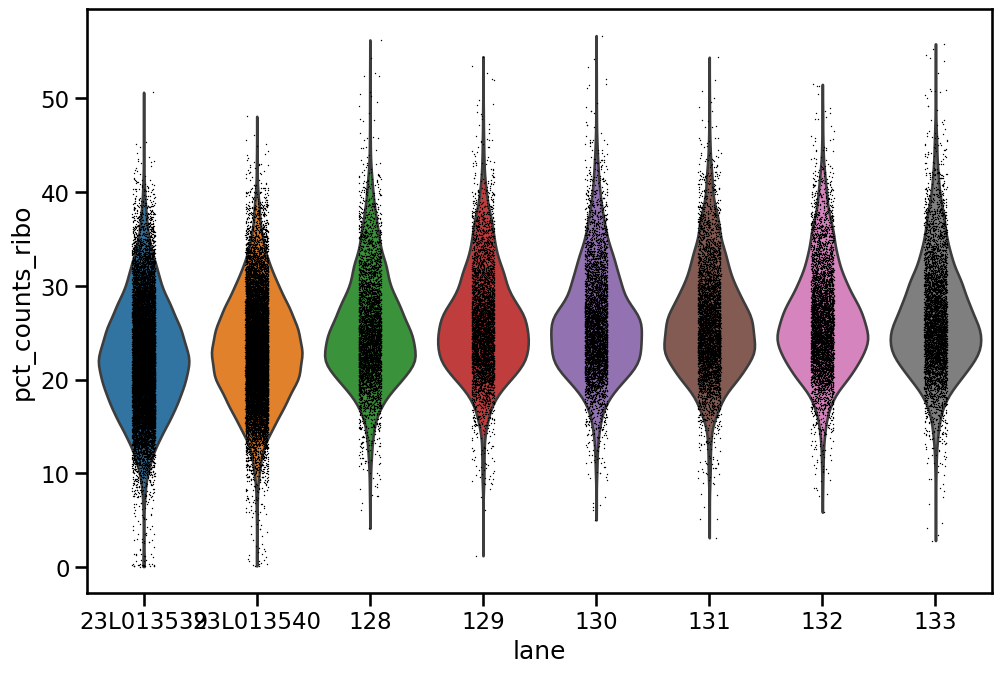

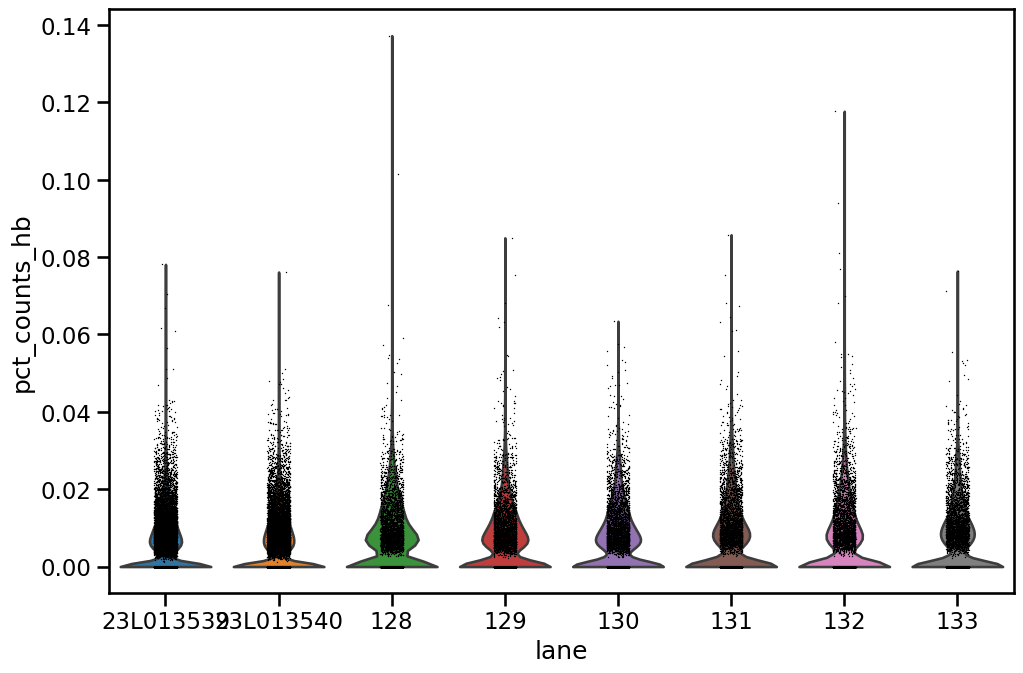

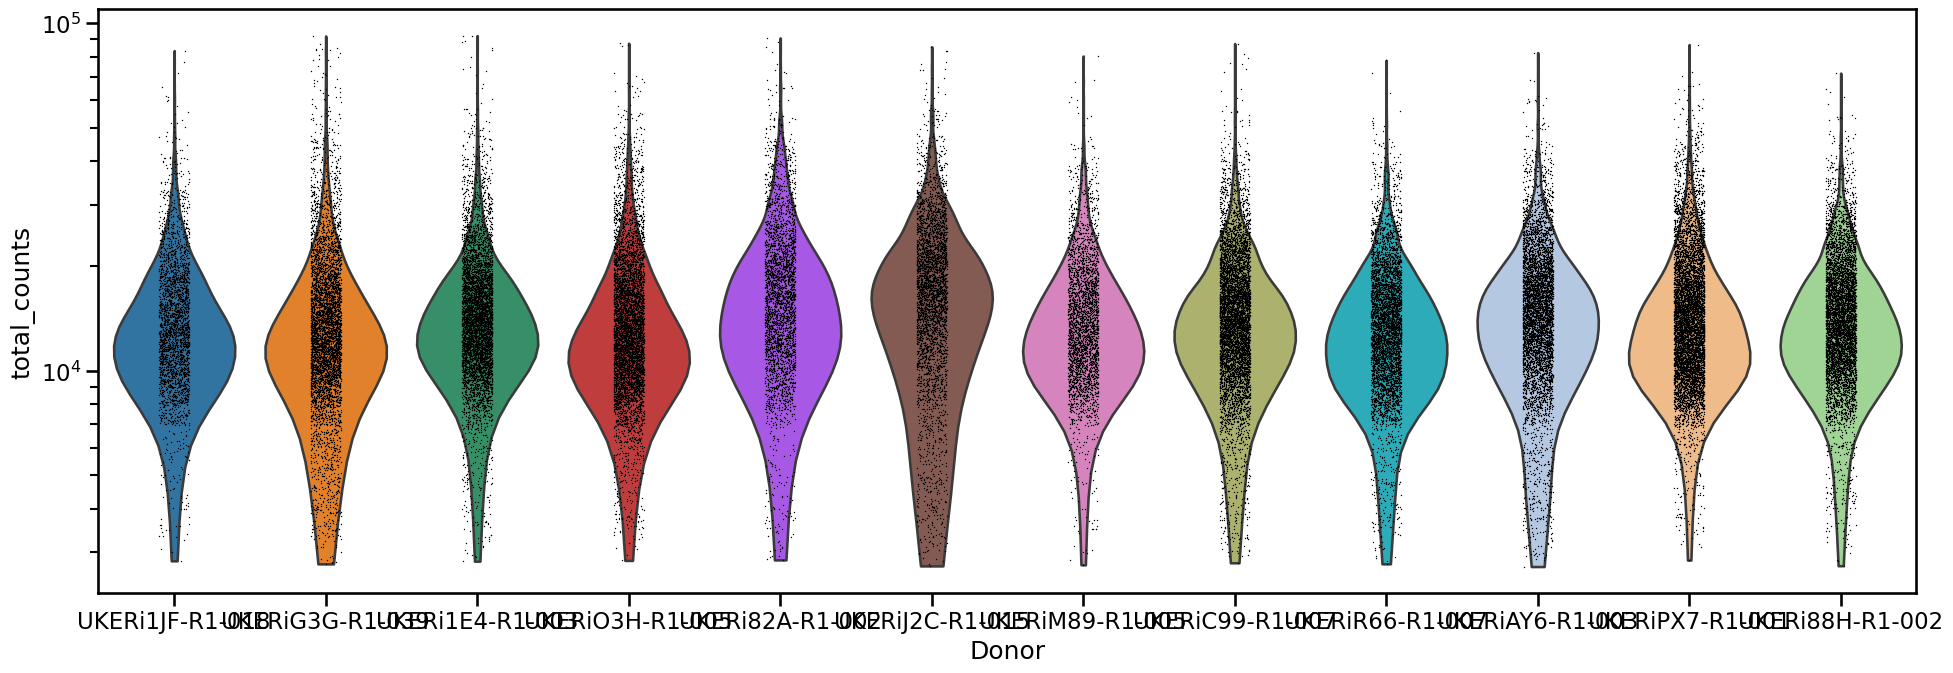

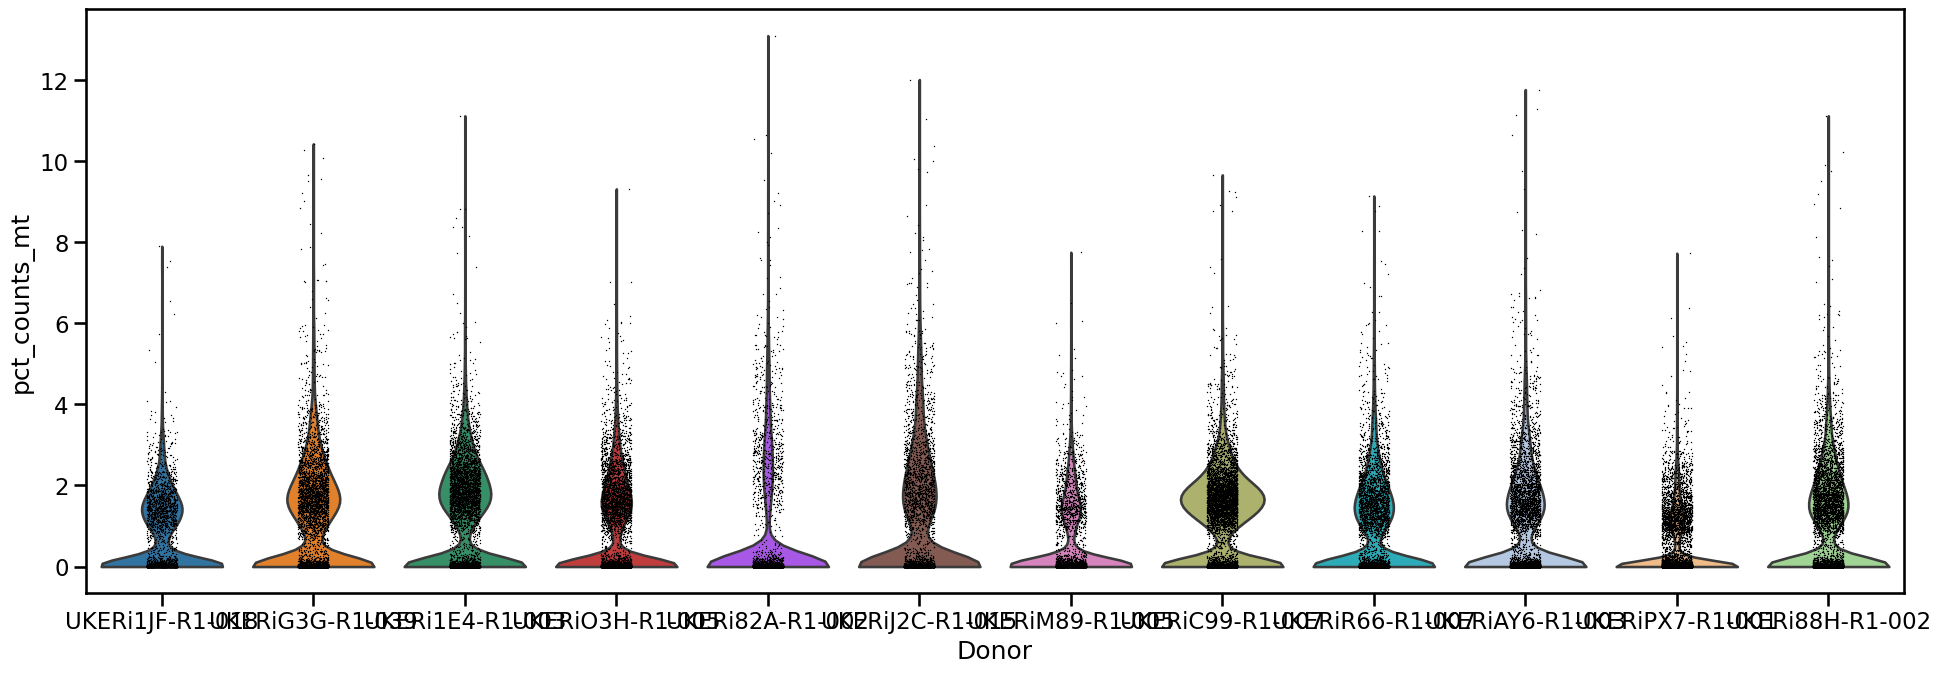

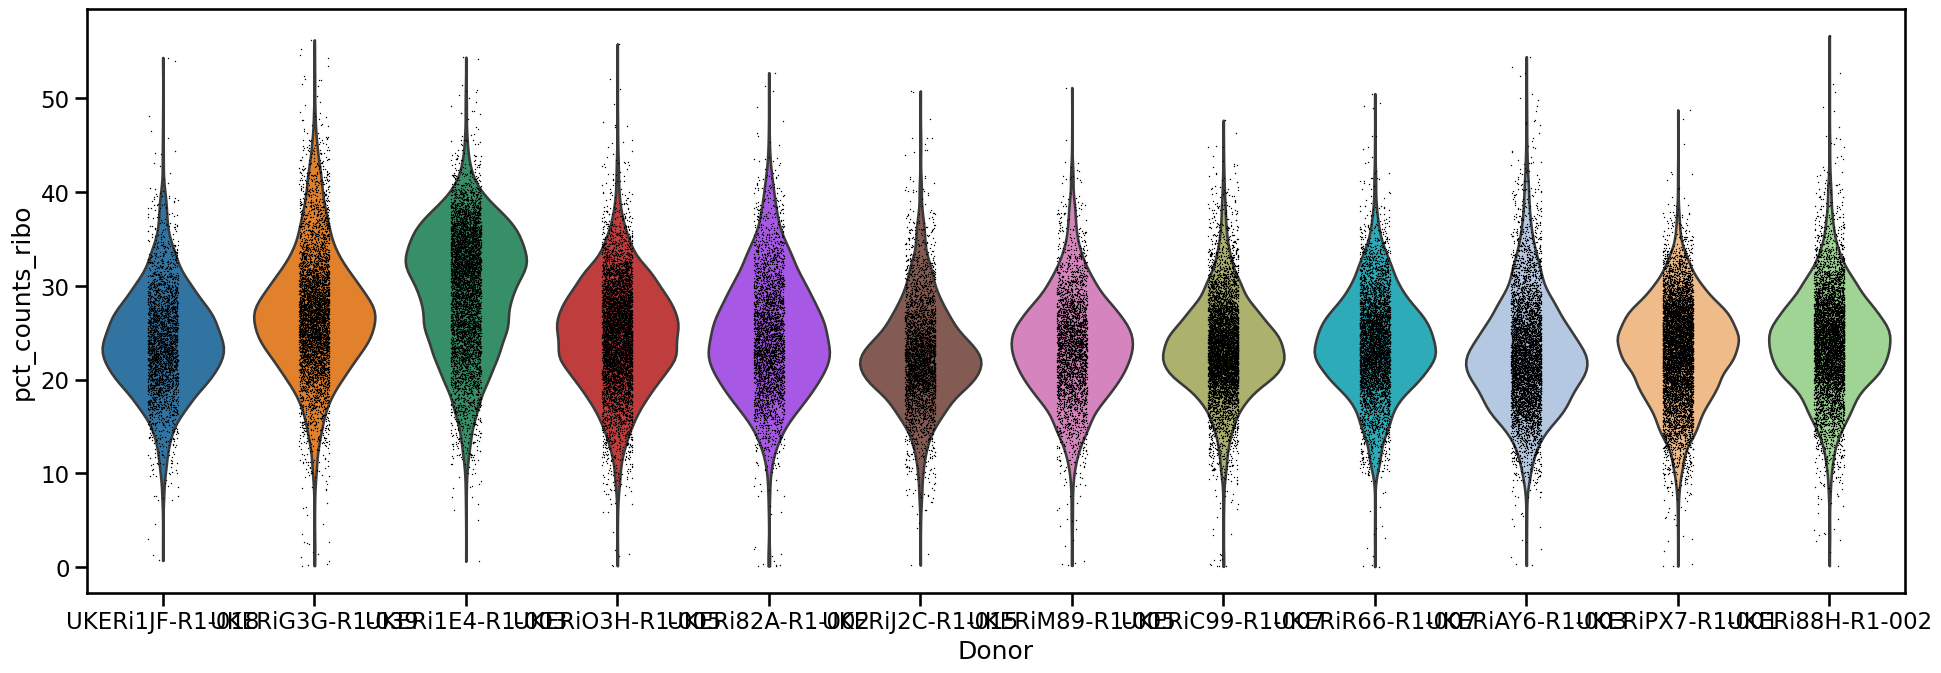

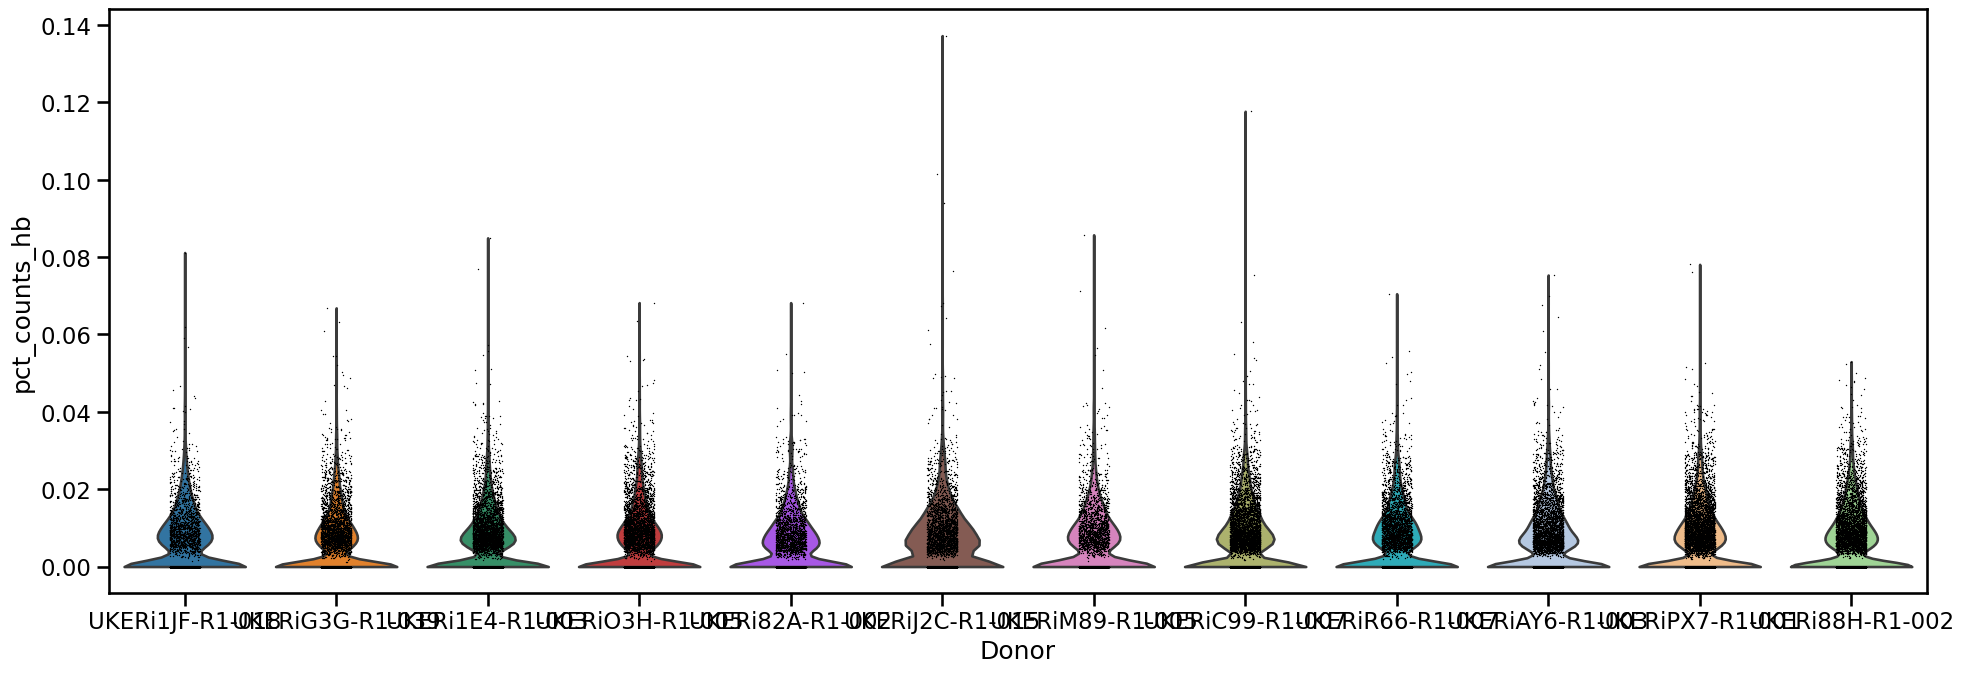

In [37]:
#Sample quality plots
plt.rcParams['figure.figsize']=(9.7,8) #rescale figures
t1 = sc.pl.violin(adata, 'total_counts', groupby='lane', log=True, cut=0, show=False)
plt.savefig(save_dir+'figures/QC/Lanes_violin_total_counts.svg')

#plt.rcParams['figure.figsize']=(7,8) #rescale figures
t2 = sc.pl.violin(adata, 'pct_counts_mt', groupby='lane', cut=0, show=False)
plt.savefig(save_dir+'figures/QC/Lanes_violin_pct_counts_mt.svg')
t3 = sc.pl.violin(adata, 'pct_counts_ribo', groupby='lane', cut=0, show=False)
plt.savefig(save_dir+'figures/QC/Lanes_violin_pct_counts_ribo.svg')
t4 = sc.pl.violin(adata, 'pct_counts_hb', groupby='lane', show=False)
plt.savefig(save_dir+'figures/QC/Lanes_violin_pct_counts_hb.svg')

plt.rcParams['figure.figsize']=(18,8) #rescale figures
t5 = sc.pl.violin(adata, 'total_counts', groupby='Donor', log=True, cut=0, show=False)
plt.savefig(save_dir+'figures/QC/Donor_violin_total_counts.svg')
t6 = sc.pl.violin(adata, 'pct_counts_mt', groupby='Donor', cut=0, show=False)
plt.savefig(save_dir+'figures/QC/Donor_violin_pct_counts_mt.svg')
t3 = sc.pl.violin(adata, 'pct_counts_ribo', groupby='Donor', cut=0, show=False)
plt.savefig(save_dir+'figures/QC/Donor_violin_pct_counts_ribo.svg')
t4 = sc.pl.violin(adata, 'pct_counts_hb', groupby='Donor', cut=0, show=False)
plt.savefig(save_dir+'figures/QC/Donor_violin_pct_counts_hb.svg')
plt.rcParams['figure.figsize']=(8,8) #rescale figures

Clear difference in total counts per lane, but especially in mt counts per lane between the lp and hp datasets.

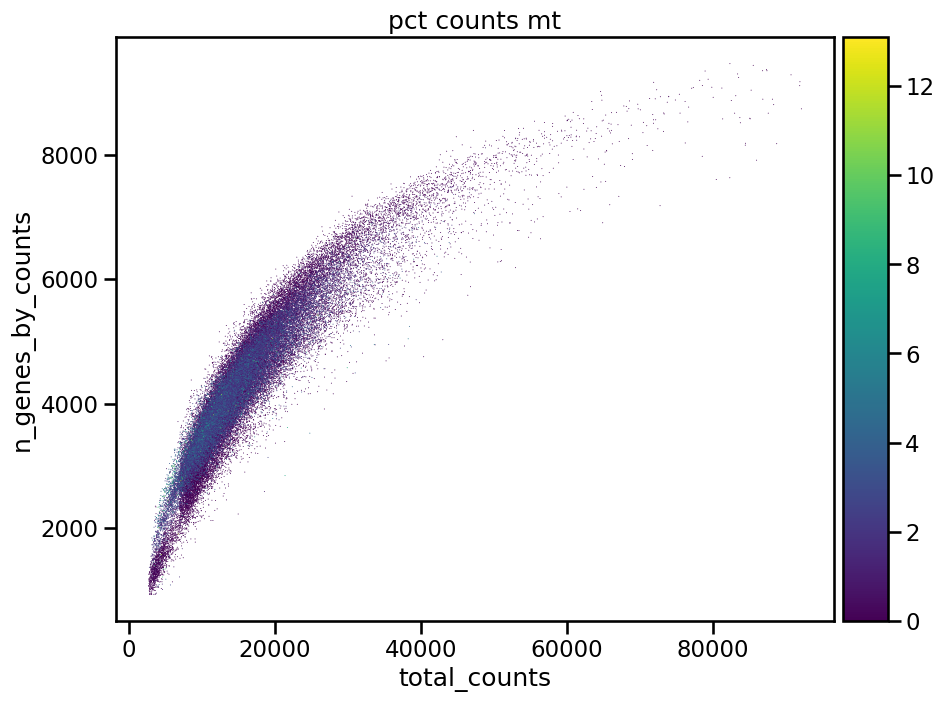

(0.0, 150000.0)

(0.0, 12000.0)

(0.0, 150000.0)

(0.0, 12000.0)

(0.0, 150000.0)

(0.0, 12000.0)

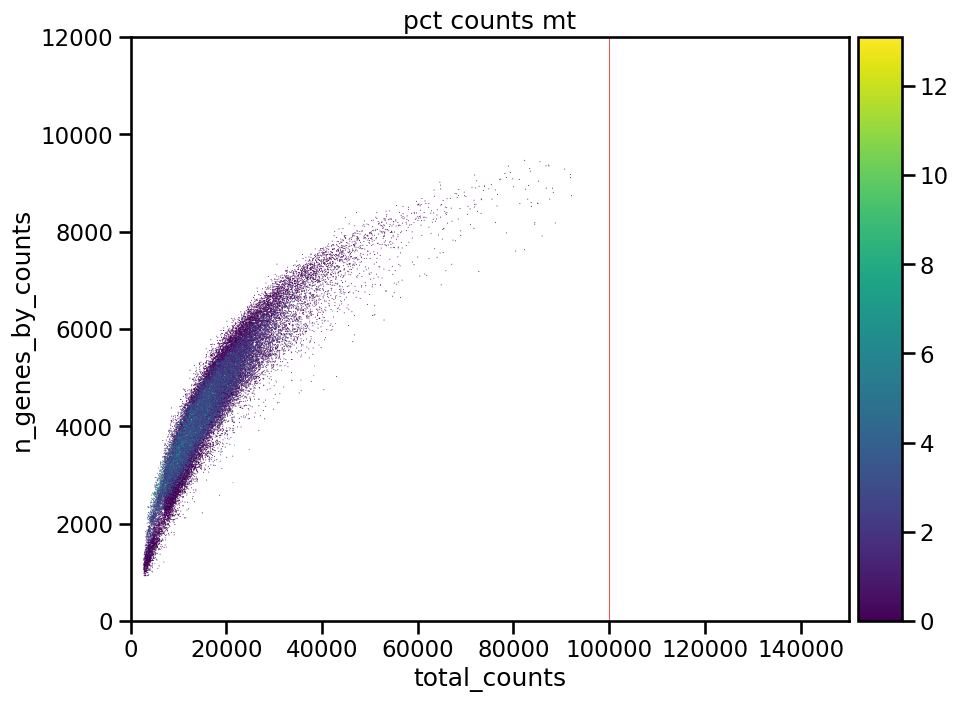

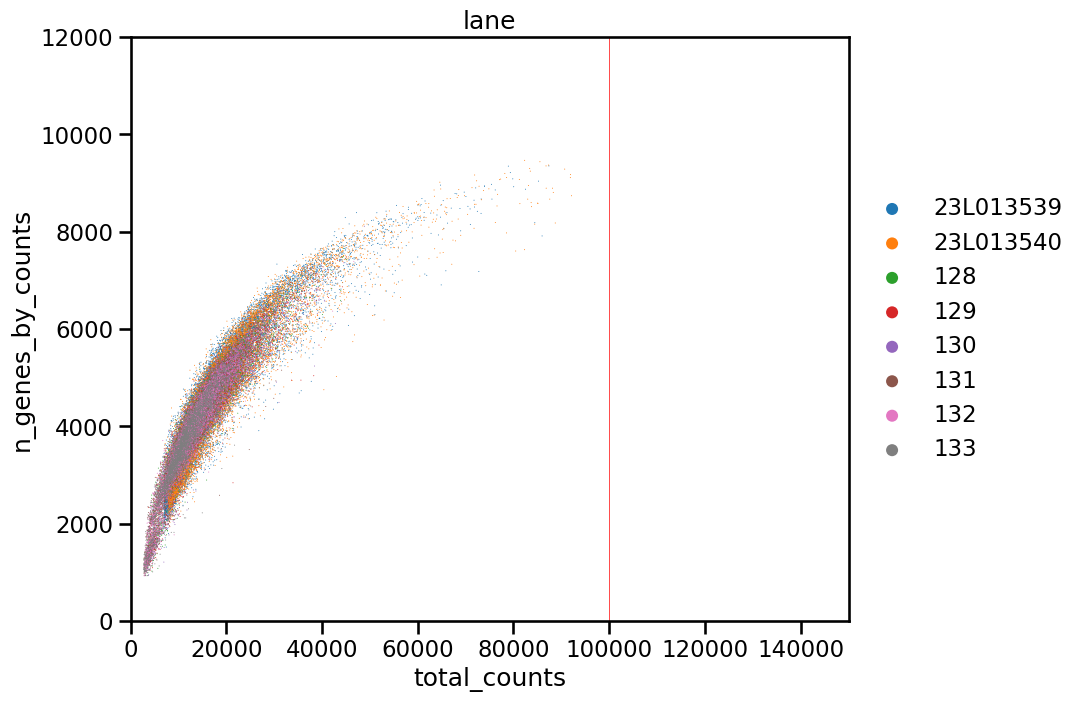

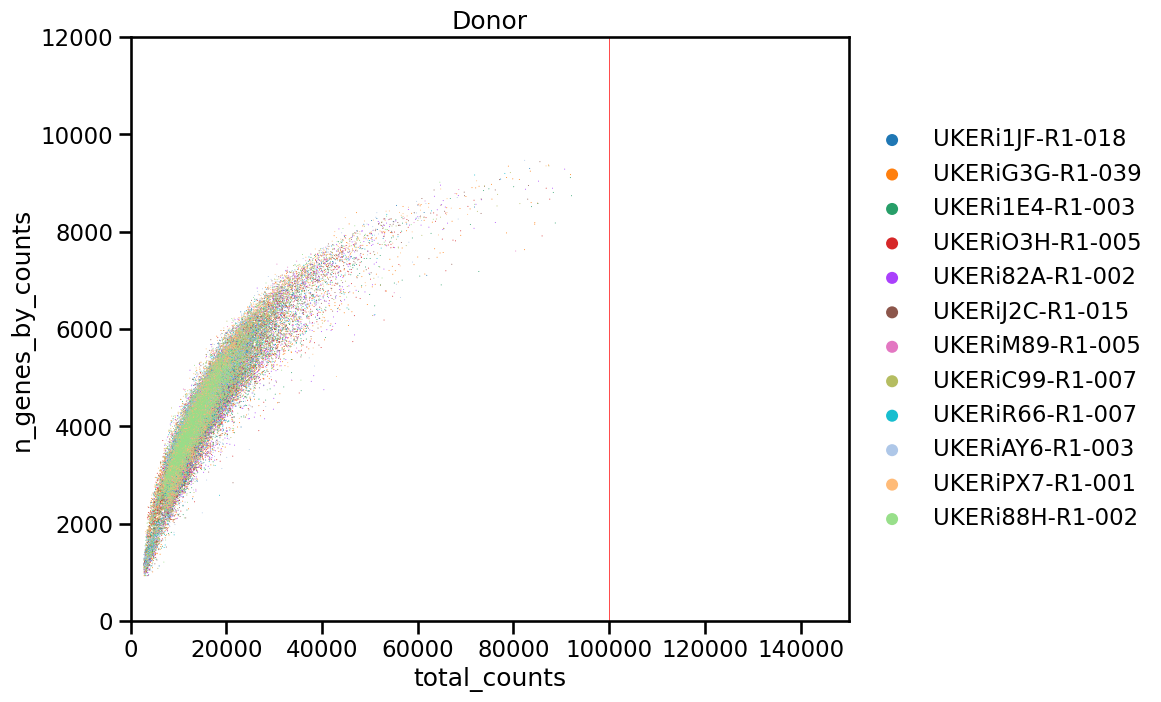

In [38]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_mt')
p2 = sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_mt', show=False)
p2.set_xlim(0,150000)
p2.set_ylim(0,12000)
p2.axvline(100000,0,9000, color='red', linewidth=0.5)
p3 = sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='lane', show=False)
p3.set_xlim(0,150000)
p3.set_ylim(0,12000)
p3.axvline(100000,0,9000, color='red', linewidth=0.5)
p4 = sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='Donor', show=False)
p4.set_xlim(0,150000)
p4.set_ylim(0,12000)
p4.axvline(100000,0,9000, color='red', linewidth=0.5)



(0.0, 150000.0)

(0.0, 12000.0)

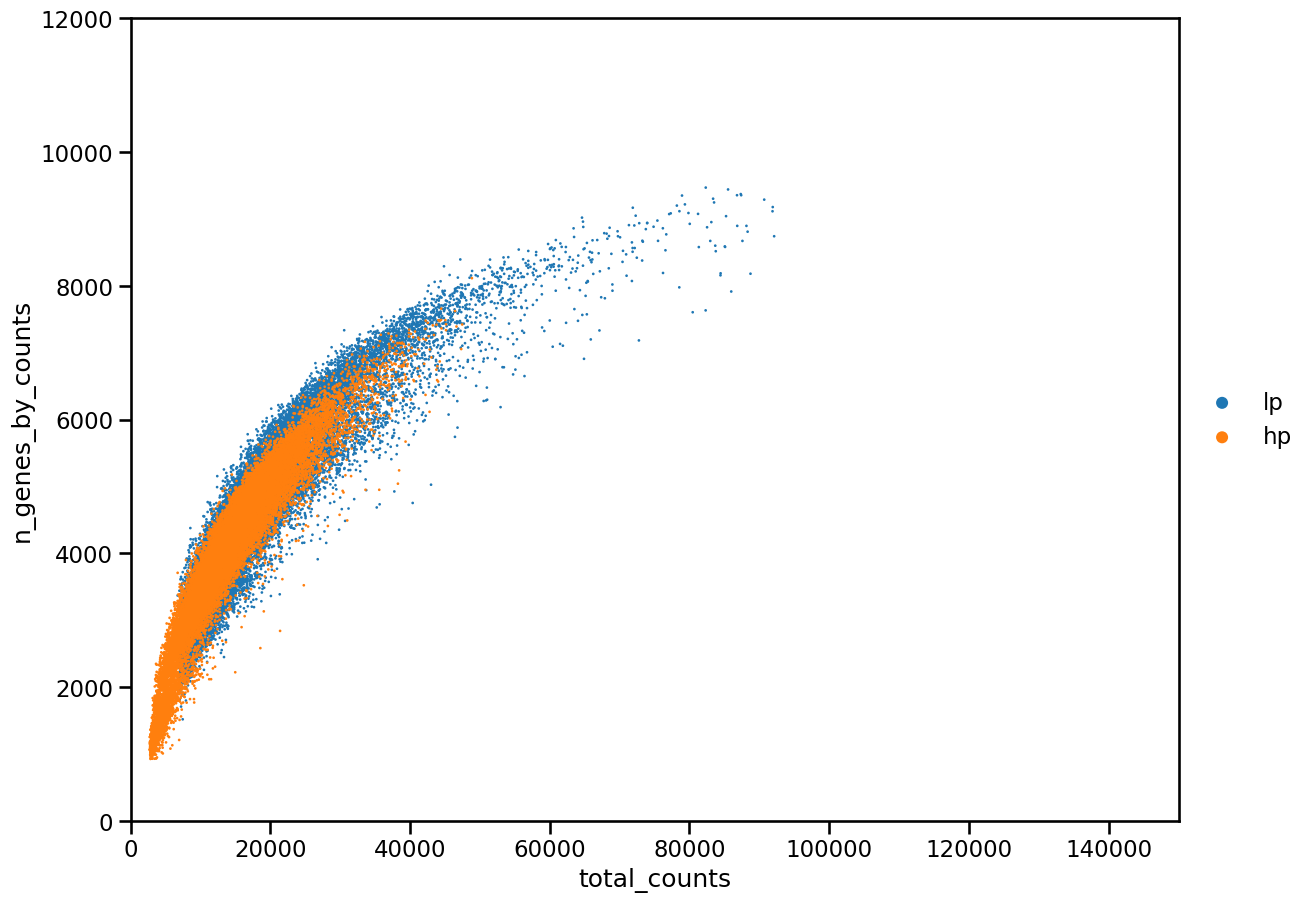

In [39]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0.2, 1, 150))
colors3 = plt.cm.Greys_r(np.linspace(0.5,0.55,30))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

# QC plot for manuscript
plt.rcParams['figure.figsize']=(11,11) #rescale figures
p1 = sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', show=False, title='', size=15, color=dataset_key)
p1.set_xlim(0,150000)
p1.set_ylim(0,12000)
plt.savefig(save_dir+'figures/QC/scatter_figure_qcplot_after-filtering.svg')
plt.rcParams['figure.figsize']=(8,8) #rescale figures

# Normalization

## scran normalization 

In [40]:
# Preliminary clustering for differentiated normalisation
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, target_sum = 1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups", resolution=0.5)

normalizing counts per cell
    finished (0:00:01)
computing PCA
    with n_comps=15
    finished (0:01:06)
computing neighbors
    using 'X_pca' with n_pcs = 15


2024-05-22 15:18:19.090438: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:37)
running Leiden clustering
    finished: found 18 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:50)


In [41]:
data_mat = adata.X.T

if sp.sparse.issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()
ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata_pp.obs["groups"]

In [42]:
del adata_pp

In [43]:
%%R -o size_factors

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam()
    )
)

In addition: Warning messages:
1: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages
2: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


In [44]:
adata.obs['size_factors'] = size_factors

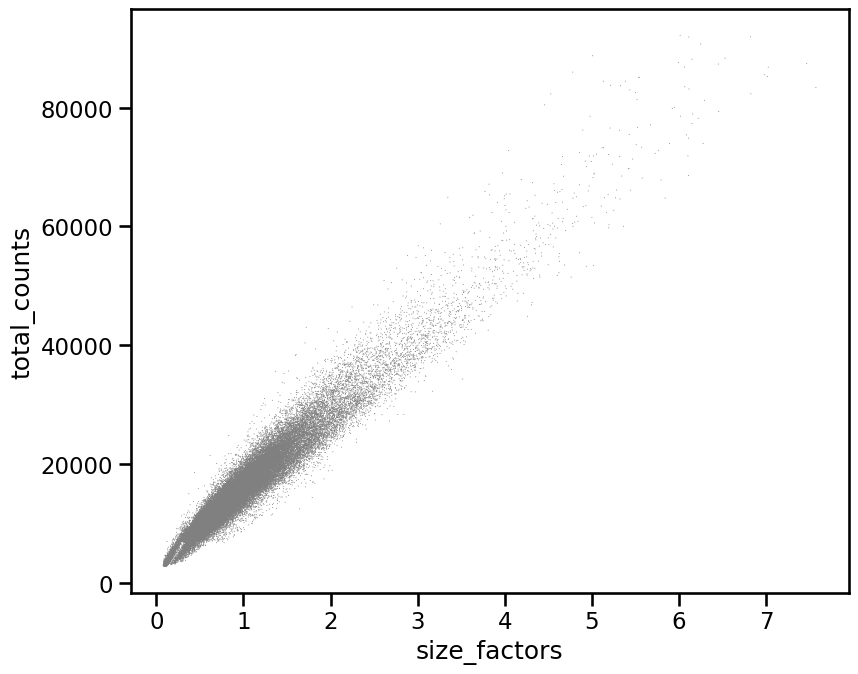

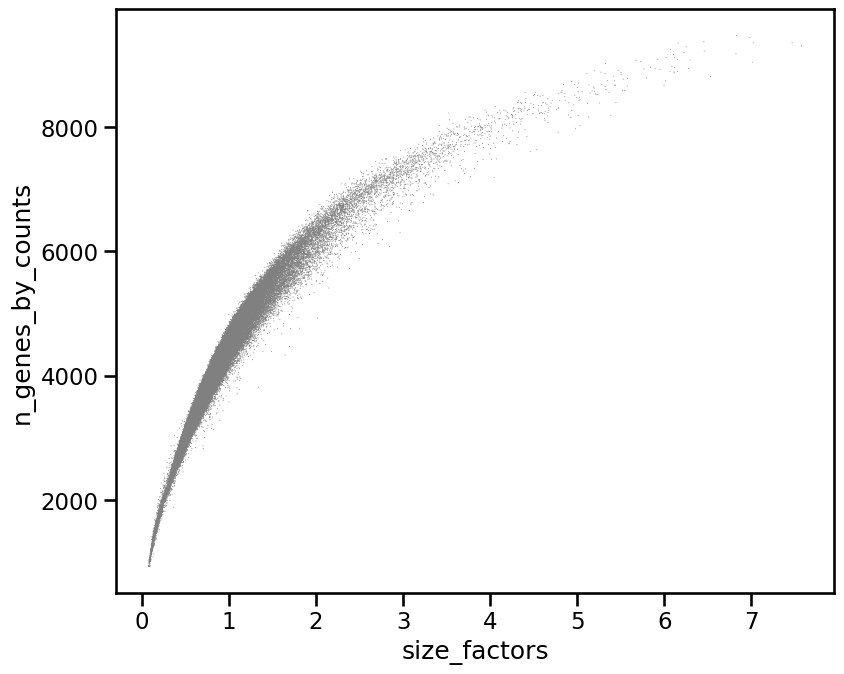

<Axes: ylabel='Count'>

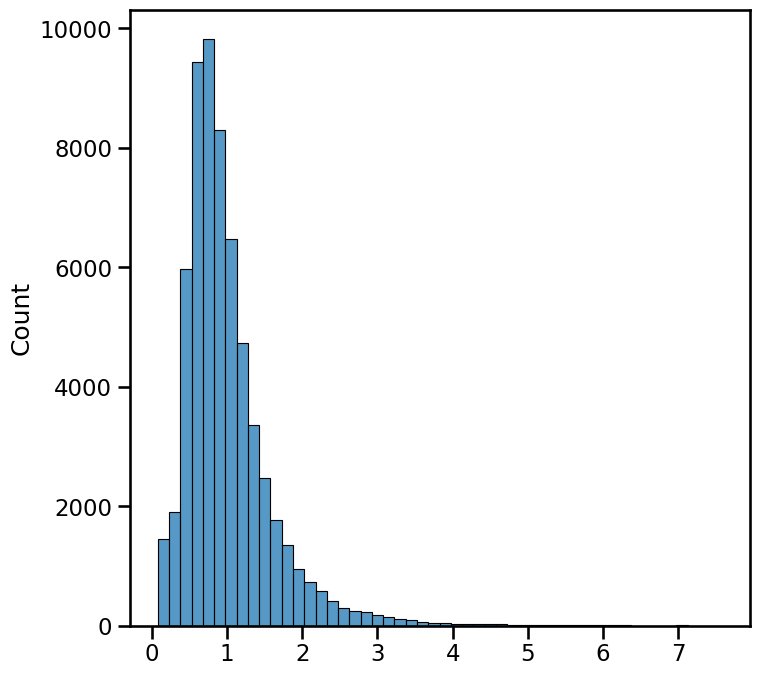

In [45]:
# Visualize the estimated size factors

sc.pl.scatter(adata, 'size_factors', 'total_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes_by_counts')

sb.histplot(size_factors, bins=50, kde=False)
plt.show()

We plot the size factors to show they are non-negative and related to the number of counts and genes per cell as expected.

In [46]:
#Normalize adata 
scran = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran))

In [47]:
%%R
rm(list = ls())

## log1p proportional fitting

In [48]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

normalizing counts per cell
    finished (0:00:03)


#  Feature selection

In [49]:
#Use scran normalized counts
adata.X = adata.layers["scran_normalization"]

In [50]:
sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor="cell_ranger")

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [51]:
adata.var['highly_variable_genes'] = adata.var['highly_variable']

## Visualization

<Axes: xlabel='means', ylabel='dispersions'>

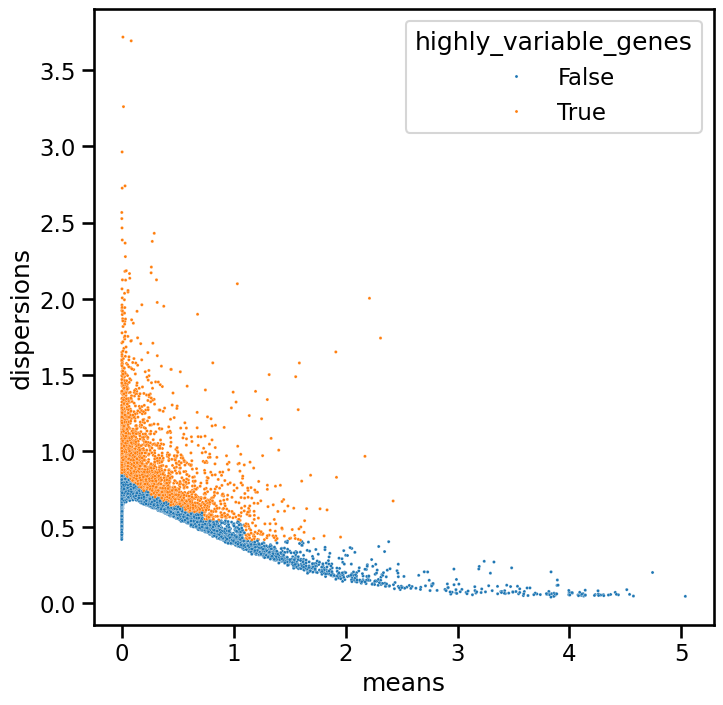

In [52]:
sb.scatterplot(
    data=adata.var, x="means", y="dispersions", hue="highly_variable_genes", s=5)
plt.show()

## Dimensionality reduction

In [53]:
adata.var['highly_variable'] = adata.var['highly_variable_genes']
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver="arpack")
sc.pp.neighbors(adata)

computing PCA
    with n_comps=50
    finished (0:00:41)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


In [54]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:39)


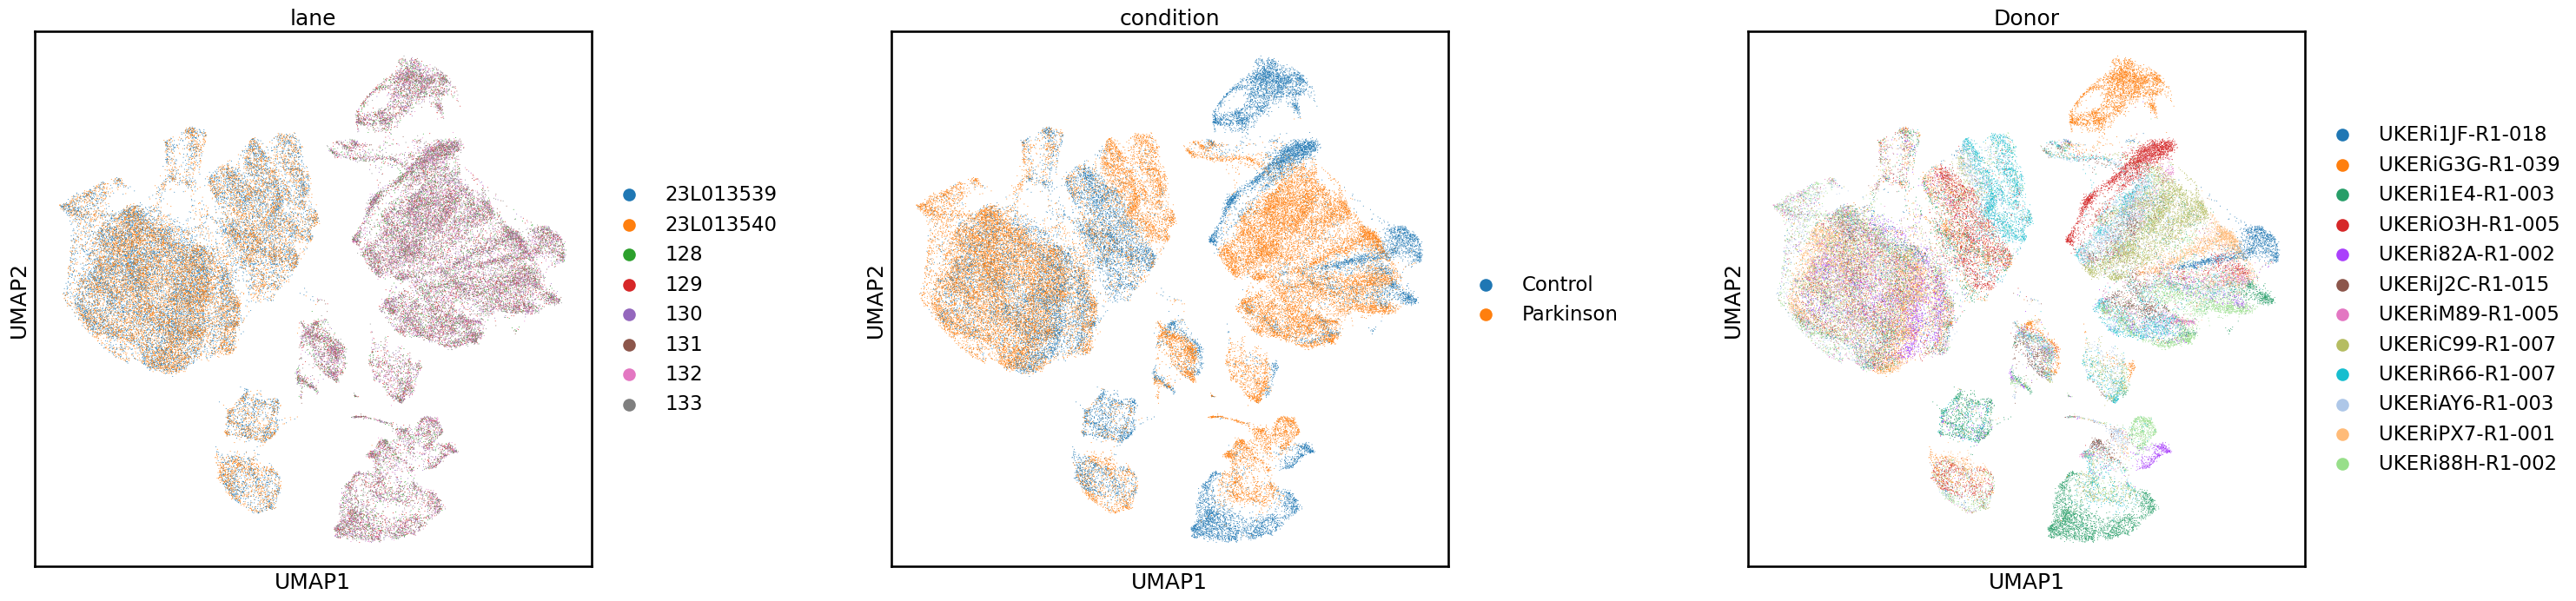

In [55]:
sc.pl.umap(adata, color=["lane","condition", "Donor"], wspace = 0.4)

# Cell cycle scoring

In [56]:
#%%R
#library(RCurl)
#cc_file <- getURL("https://raw.githubusercontent.com/hbc/tinyatlas/master/cell_cycle/Homo_sapiens.csv") 
#cell_cycle_genes <- read.csv(text = cc_file)

In [57]:
#%%R -o cell_cycle_genes
#library(biomaRt)
#gene_symbols <- as.character(cell_cycle_genes$geneID)

#mart = useDataset("hsapiens_gene_ensembl", useEnsembl(biomart="ensembl", version=108))

#attribute <- c("ensembl_gene_id", "external_gene_name", "hgnc_symbol")

#G_list <- getBM(filters= "ensembl_gene_id", attributes= attribute,values=gene_symbols,mart=mart)



#cell_cycle_genes$ensemblID = G_list[match(gene_symbols, G_list$ensembl_gene_id),]$ensembl_gene_id
#cell_cycle_genes$symbol = G_list[match(gene_symbols, G_list$ensembl_gene_id),]$hgnc_symbol

#write.csv(cell_cycle_genes, 'general_input_files/cc_genes_tirosh_human.txt', row.names = FALSE)

In [58]:
cell_cycle_genes = pd.read_csv('general_input_files/cc_genes_tirosh_human.txt')

In [59]:
cell_cycle_genes

phase           geneID modified        ensemblID  symbol
0   G2/M  ENSG00000010292  9/13/17  ENSG00000010292  NCAPD2
1   G2/M  ENSG00000011426  9/13/17  ENSG00000011426    ANLN
2   G2/M  ENSG00000013810  9/13/17  ENSG00000013810   TACC3
3   G2/M  ENSG00000072571  9/13/17  ENSG00000072571    HMMR
4   G2/M  ENSG00000075218  9/13/17  ENSG00000075218   GTSE1
..   ...              ...      ...              ...     ...
92     S  ENSG00000175305  9/13/17  ENSG00000175305   CCNE2
93     S  ENSG00000176890  9/13/17  ENSG00000176890    TYMS
94     S  ENSG00000197299  9/13/17  ENSG00000197299     BLM
95     S  ENSG00000198056  9/13/17  ENSG00000198056   PRIM1
96     S  ENSG00000276043  9/13/17  ENSG00000276043   UHRF1

[97 rows x 5 columns]

In [60]:
cell_cycle_genes = cell_cycle_genes[cell_cycle_genes.symbol.isin(adata.var.gene_symbols)]
s_genes = cell_cycle_genes[cell_cycle_genes.phase == 'S'].symbol.values.tolist()
g2m_genes = cell_cycle_genes[cell_cycle_genes.phase == 'G2/M'].symbol.values.tolist()

In [61]:
#Score cell cycle and visualize the effect:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    512 total control genes are used. (0:00:04)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    427 total control genes are used. (0:00:04)
-->     'phase', cell cycle phase (adata.obs)


In [62]:
adata.obs.phase.value_counts()

phase
G1     22300
G2M    19686
S      19414
Name: count, dtype: int64

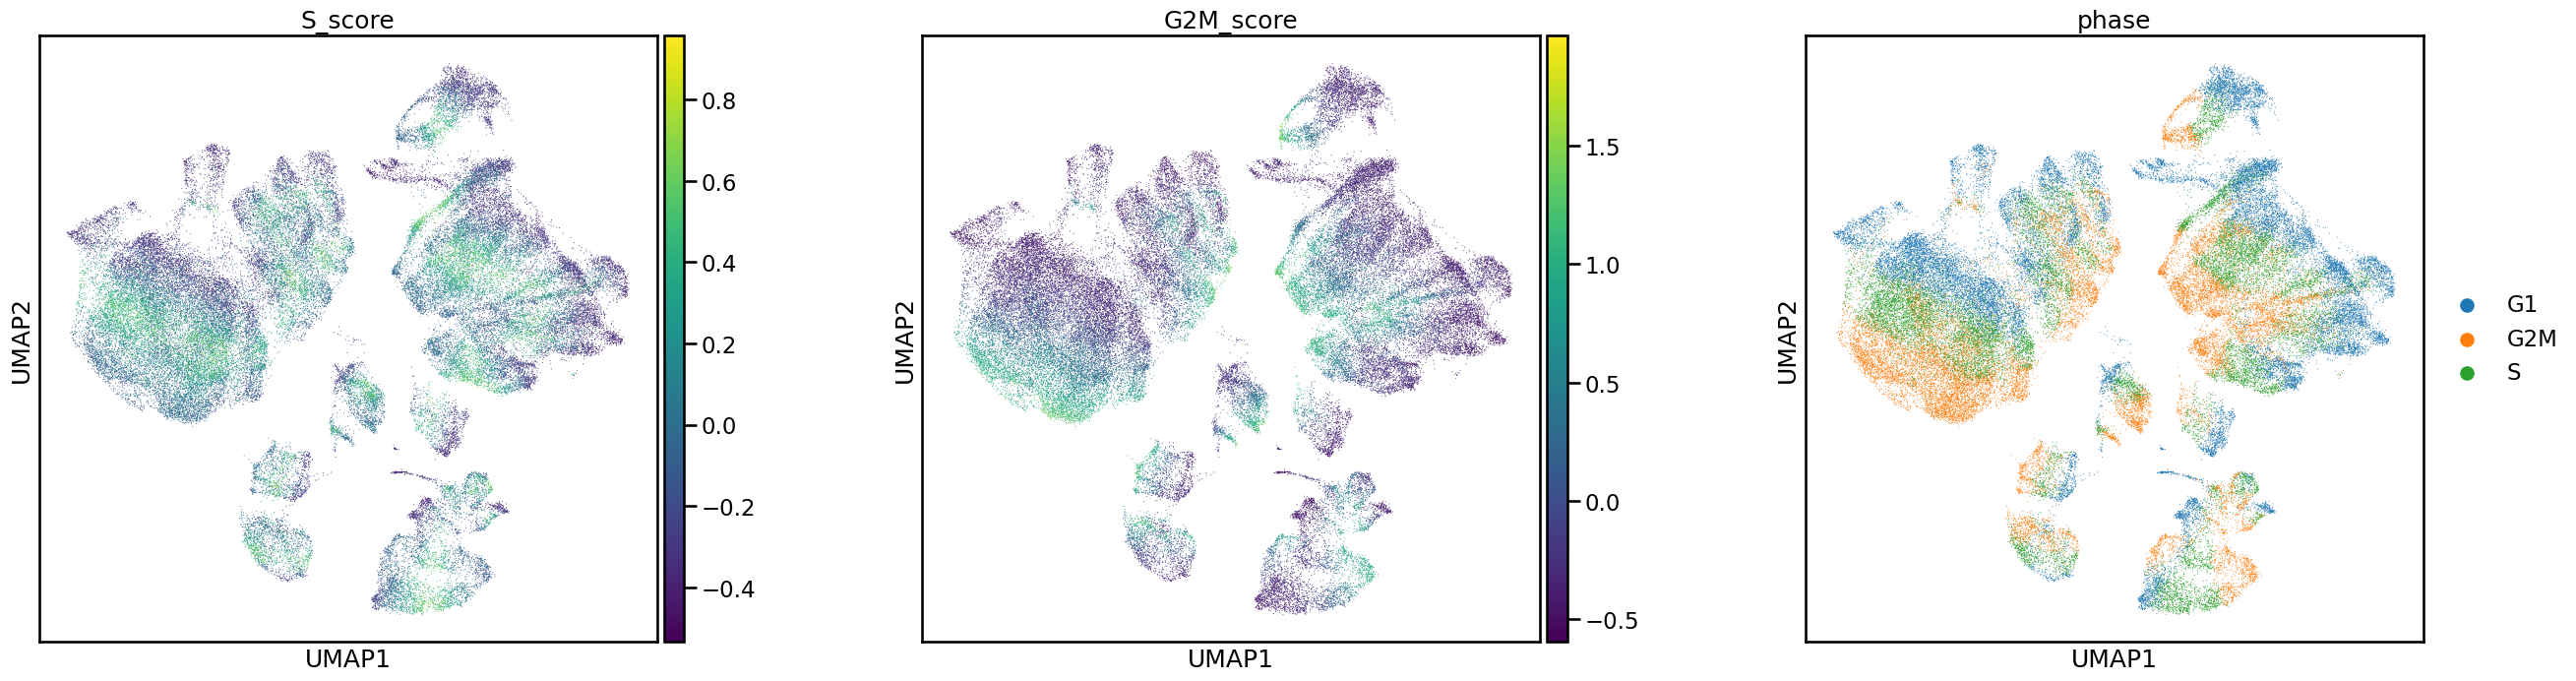

In [63]:
# Tirosh CC gene scoring
sc.pl.umap(adata, color=['S_score', 'G2M_score', 'phase'], wspace = 0.3)

# Evaluate batch effects

Here, we compute the variance contribution of covariates. 

In [64]:
adata_pca = adata.copy()

In [65]:
sc.pp.pca(adata, n_comps=50, svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:41)


In [66]:
n_pcs = 50

specifiy covariates we want to check (we will quantify their correlation with the 1st 50 PCs, to see how much variance they can each explain):

In [67]:
covariates = ['Donor', 'lane', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period', 'phase']

In [68]:
def check_if_nan(arr, *args, **kwarg):
    if isinstance(arr, np.ndarray):
        x_nans = np.isnan(arr)
    else:
        x_nans = arr.isna()
    return x_nans

Now check for every covariate, for every PC how much variance among the cells' PC scores the covariate can explain. Add this variance explained per PC up across PCs for every covariate. This will give us the total amount of variance explained per covariate.

In [69]:
var_explained = pd.DataFrame(index=range(n_pcs), columns=covariates + ["overall"])
for pc in range(n_pcs):
    y_true_unfiltered = adata_pca.obsm["X_pca"][:, pc]
    var_explained.loc[pc, "overall"] = np.var(y_true_unfiltered)
    for cov in covariates:
        x = adata_pca.obs[cov].values.copy()
        x_nans = check_if_nan(x)
        x = x[~x_nans]
        if len(x) != 0:
            y_true = y_true_unfiltered[~x_nans].reshape(-1, 1)
            if x.dtype in ["float32", "float", "float64"]:
                x = x.reshape(-1, 1)
            else:
                if len(set(x)) == 1:
                    var_explained.loc[pc, cov] = np.nan
                    continue
                x = pd.get_dummies(x)
            lrf = LinearRegression(fit_intercept=True).fit(
                x,
                y_true,
            )
            y_pred = lrf.predict(x)
            var_explained.loc[pc, cov] = np.var(y_pred)
total_variance_explained = np.sum(var_explained, axis=0).sort_values(ascending=False)
total_variance_explained_fractions = (
    total_variance_explained / total_variance_explained["overall"]
)

In [70]:
total_variance_explained.sort_values(ascending=False, inplace=True)

<Figure size 800x400 with 0 Axes>

<BarContainer object of 13 artists>

Text(0.5, 1.0, 'covariate correlation with first 50 PCs')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'age'),
  Text(1, 0, 'deltaHY'),
  Text(2, 0, 'deltaUPDRS'),
  Text(3, 0, 'gender'),
  Text(4, 0, 'condition'),
  Text(5, 0, 'deltaADL'),
  Text(6, 0, 'years_of_illness'),
  Text(7, 0, 'deltaDOPA'),
  Text(8, 0, 'Donor'),
  Text(9, 0, 'phase'),
  Text(10, 0, 'cultivation_period'),
  Text(11, 0, 'lane'),
  Text(12, 0, 'overall')])

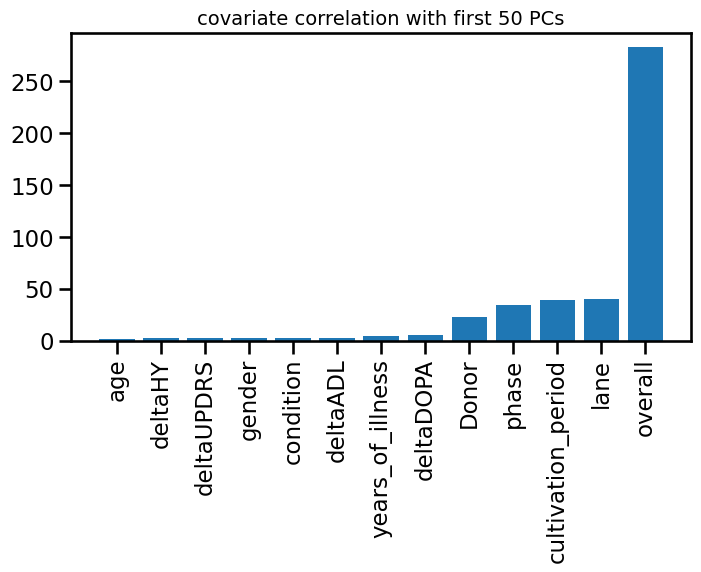

In [71]:
plt.figure(figsize=(8, 4))
plt.bar(
    total_variance_explained[::-1].index,
    total_variance_explained[::-1].values,
)
plt.title(
    f"covariate correlation with first 50 PCs",
    fontsize=14,
)  # \n({dominant_type})
plt.xticks(rotation=90)
plt.show()

We will consider donor and cultivation_period as batch effect. Dataset will be corrected for the cell cycle phase in the next steps to refine clustering.

In [72]:
del adata_pca

#  Feature selection - batch aware

In [73]:
# Create unique ID containing the donor and cultivation period key.
adata.obs['donor_batch_ID'] = pd.Categorical(adata.obs['Donor'].astype('str') + adata.obs[dataset_key].astype('str'))

In [74]:
sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor="cell_ranger", batch_key='donor_batch_ID')

extracting highly variable genes
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [75]:
adata.var.highly_variable.value_counts()

highly_variable
False    13366
True      4000
Name: count, dtype: int64

In [76]:
adata.var.highly_variable_intersection.value_counts()

highly_variable_intersection
False    16712
True       654
Name: count, dtype: int64

highly_variable_nbatches
0     4860
1     2215
2     1569
3     1245
4     1012
5      780
24     654
6      644
7      523
8      434
9      347
10     329
11     282
12     268
14     249
23     246
13     232
22     205
20     199
17     190
15     187
18     184
16     177
21     173
19     162
Name: count, dtype: int64

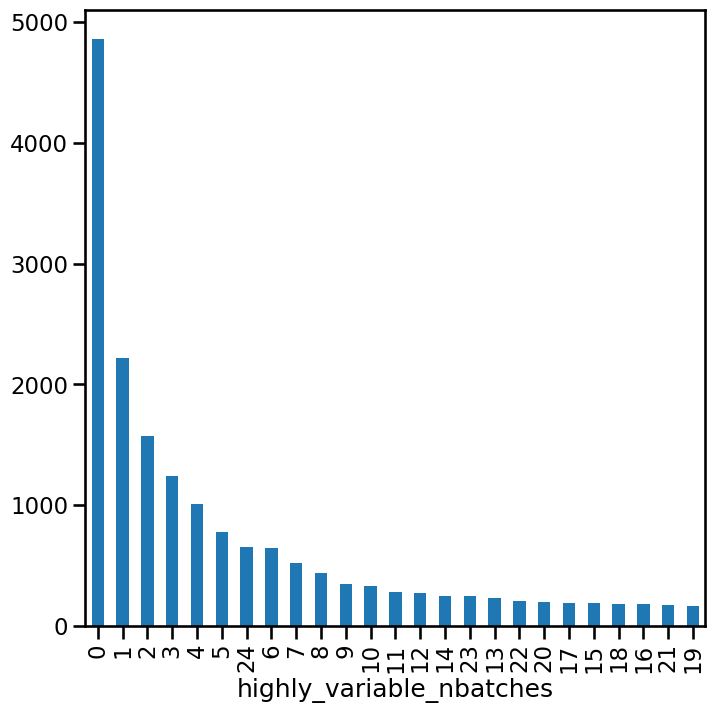

In [77]:
n_batches = adata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

In [78]:
adata.var['highly_variable_genes_batch_aware'] = adata.var['highly_variable']

## Visualization

<Axes: xlabel='means', ylabel='dispersions'>

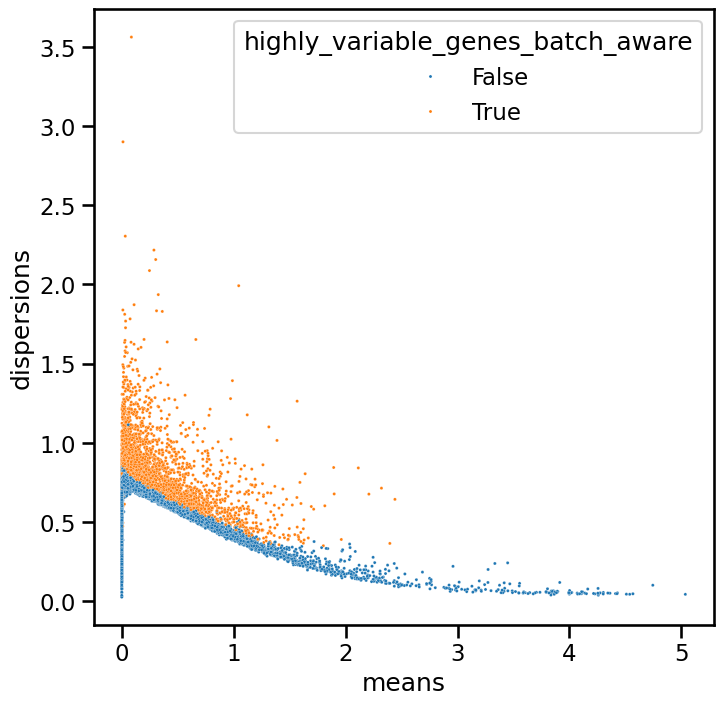

In [79]:
sb.scatterplot(
    data=adata.var, x="means", y="dispersions", hue="highly_variable_genes_batch_aware", s=5)
plt.show()

## Dimensionality reduction

In [80]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver="arpack")
sc.pp.neighbors(adata)

computing PCA
    with n_comps=50
    finished (0:00:45)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)


In [81]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)


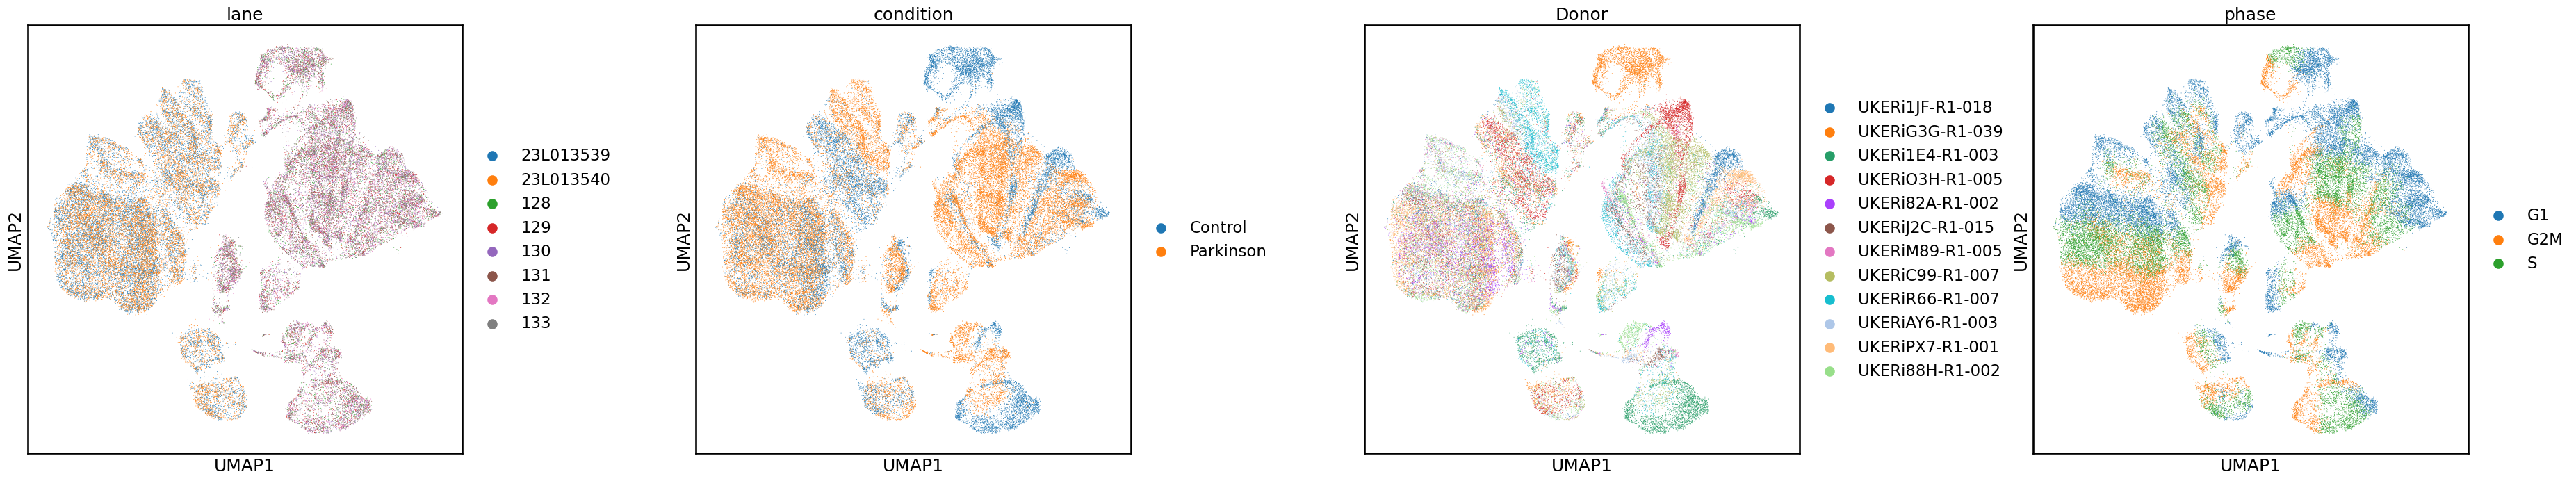

In [82]:
sc.pl.umap(adata, color=["lane","condition", "Donor", 'phase'], wspace = 0.4)

# Write data to file

In [83]:
adata.raw = adata

In [84]:
adata.write(adata_out_cell_cycle)